# MAPK8IP3
[neurodevelopmental disorder with or without variable brain abnormalities (NEDBA)](https://omim.org/entry/618443) is caused by heterozygous mutation in the MAPK8IP3 gene.

In [1]:
import gpsea
import hpotk

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo()
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2024-12-12
Using gpsea version 0.9.0


## MAPK8IP3
We user the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for ASPM.

In [2]:
gene_symbol = 'MAPK8IP3'
mane_tx_id = 'NM_001318852.2'
mane_protein_id = 'NP_001305781.1' # C-Jun-amino-terminal kinase-interacting protein 3 isoform 3

In [3]:
from ppktstore.registry import configure_phenopacket_registry
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets


phenopacket_store_release = '0.1.22'
registry = configure_phenopacket_registry()

with registry.open_phenopacket_store(release=phenopacket_store_release) as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))

cohort_creator = configure_caching_cohort_creator(hpo)

cohort, qc = load_phenopackets(
    phenopackets=phenopackets, 
    cohort_creator=cohort_creator,
)
print(f'Loaded {len(cohort)} individuals')
qc.summarize()

Individuals Processed: 100%|██████████| 20/20 [00:00<00:00, 682.39individuals/s]
Loaded 20 individuals
Validated under permissive policy
No errors or warnings were found


In [4]:
from gpsea.view import CohortViewer

cv = CohortViewer(hpo)
cv.process(cohort, transcript_id=mane_tx_id)

n,HPO Term
19,Global developmental delay
11,Hypotonia
9,Thin corpus callosum
7,"Intellectual disability, moderate"
6,Intellectual disability
6,Spastic diplegia
6,Delayed ability to walk
6,Seizure
5,Cerebral atrophy
5,Thin upper lip vermilion


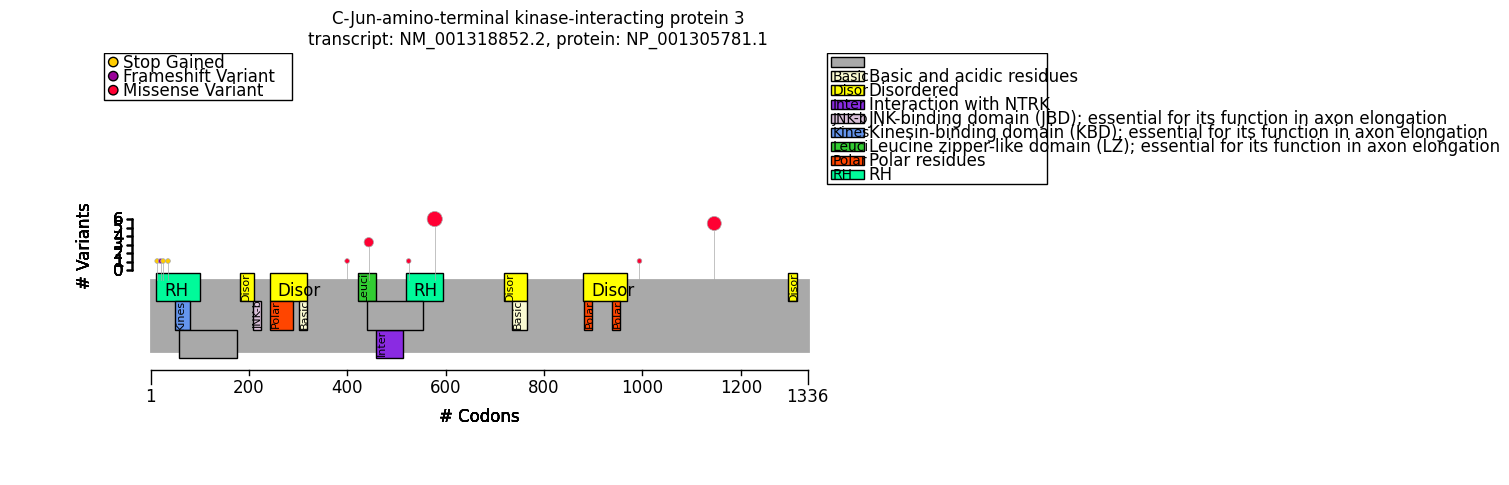

In [5]:
from gpsea.model.genome import GRCh38
from gpsea.preprocessing import configure_default_protein_metadata_service, VVMultiCoordinateService
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt

txc_service = VVMultiCoordinateService(genome_build=GRCh38)
pms = configure_default_protein_metadata_service()
tx_coordinates = txc_service.fetch(mane_tx_id)
protein_meta = pms.annotate(mane_protein_id)

mapk8ip3_fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein_diagram(
    tx_coordinates,
    protein_meta,
    cohort,
    ax=ax,
)
mapk8ip3_fig.tight_layout()

In [6]:
from gpsea.view import ProteinVariantViewer
pvv = ProteinVariantViewer(protein_metadata=protein_meta, tx_id=mane_tx_id)
pvv.process(cohort=cohort)

Count,Name,Type,Coordinates,Variants
4,RH1,Domain,13 - 100,p.Tyr15Ter; p.Glu27Ter; p.Gly22AlafsTer3; p.Tyr37Ter
0,Kinesin-binding domain (KBD); essential for its function in axon elongation,Region,51 - 80,
0,,Coiled coil,59 - 177,
0,Disordered,Region,183 - 211,
0,JNK-binding domain (JBD); essential for its function in axon elongation,Region,210 - 225,
0,Disordered,Region,244 - 318,
0,Polar residues,Compositional bias,244 - 289,
0,Basic and acidic residues,Compositional bias,304 - 318,
2,Leucine zipper-like domain (LZ); essential for its function in axon elongation,Region,424 - 458,p.Leu445Pro
3,,Coiled coil,441 - 554,p.Leu445Pro; p.Arg526Gln


# Genotype-Phenotype Correlation (GPC) Analysis

In [7]:
from gpsea.analysis.clf import prepare_classifiers_for_terms_of_interest
from gpsea.analysis.pcats import configure_hpo_term_analysis

pheno_clfs = prepare_classifiers_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)
analysis = configure_hpo_term_analysis(hpo)

In [8]:
from gpsea.view import MtcStatsViewer
from gpsea.model.genome import Region
from gpsea.analysis.predicate import variant_effect, protein_region
from gpsea.analysis.predicate import VariantPredicate as vp


from gpsea.analysis.clf import monoallelic_classifier


n_term = protein_region(region=Region(0, 600), tx_id=mane_tx_id)
n_term_classifier = monoallelic_classifier(
    a_predicate=n_term,
    b_predicate=~n_term,
    a_label="N term",
    b_label="other"
)

n_term_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=n_term_classifier,
    pheno_clfs=pheno_clfs
)


viewer = MtcStatsViewer()
viewer.process(n_term_result)

Code,Reason,Count
HMF01,Skipping term with maximum frequency that was less than threshold 0.4,7
HMF03,Skipping term because of a child term with the same individual counts,5
HMF08,Skipping general term,63
HMF09,Skipping term with maximum annotation frequency that was less than threshold 0.4,227


In [9]:
from gpsea.view import summarize_hpo_analysis

summarize_hpo_analysis(hpo=hpo, result=n_term_result)

Allele group                                       N term         other  \
                                                    Count Percent Count   
Gait disturbance [HP:0001288]                         3/8     38%   2/3   
Seizure [HP:0001250]                                 5/12     42%   1/6   
Global developmental delay [HP:0001263]             13/13    100%   6/6   
Neurodevelopmental delay [HP:0012758]               13/13    100%   6/6   
Neurodevelopmental abnormality [HP:0012759]         14/14    100%   6/6   
Intellectual disability [HP:0001249]                13/13    100%   6/6   
Thin corpus callosum [HP:0033725]                     6/7     86%   3/3   
Abnormal corpus callosum morphology [HP:0001273]      6/6    100%   4/4   
Abnormal cerebral white matter morphology [HP:0...    6/6    100%   4/4   
Abnormal cerebral morphology [HP:0002060]             8/8    100%   4/4   
Abnormal brain morphology [HP:0012443]                9/9    100%   4/4   
Morphological central nervous system abnormalit...    9/9    100%   4/4   
Appendicular spasticity [HP:0034353]                  6/6    100%   2/2   
Spasticity [HP:0001257]                               7/7    100%   3/3   
Upper motor neuron dysfunction [HP:0002493]           7/7    100%   3/3   
Abnormal muscle tone [HP:0003808]                   12/12    100%   6/6   
Abnormal oral cavity morphology [HP:0000163]          6/6    100%   3/3   
Hypotonia [HP:0001252]                               7/12     58%   4/6   

Allele group                                                                   \
                                                   Percent Corrected p values   
Gait disturbance [HP:0001288]                          67%                1.0   
Seizure [HP:0001250]                                   17%                1.0   
Global developmental delay [HP:0001263]               100%                1.0   
Neurodevelopmental delay [HP:0012758]                 100%                1.0   
Neurodevelopmental abnormality [HP:0012759]           100%                1.0   
Intellectual disability [HP:0001249]                  100%                1.0   
Thin corpus callosum [HP:0033725]                     100%                1.0   
Abnormal corpus callosum morphology [HP:0001273]      100%                1.0   
Abnormal cerebral white matter morphology [HP:0...    100%                1.0   
Abnormal cerebral morphology [HP:0002060]             100%                1.0   
Abnormal brain morphology [HP:0012443]                100%                1.0   
Morphological central nervous system abnormalit...    100%                1.0   
Appendicular spasticity [HP:0034353]                  100%                1.0   
Spasticity [HP:0001257]                               100%                1.0   
Upper motor neuron dysfunction [HP:0002493]           100%                1.0   
Abnormal muscle tone [HP:0003808]                     100%                1.0   
Abnormal oral cavity morphology [HP:0000163]          100%                1.0   
Hypotonia [HP:0001252]                                 67%                1.0   

Allele group                                                  
                                                    p values  
Gait disturbance [HP:0001288]                       0.545455  
Seizure [HP:0001250]                                0.600032  
Global developmental delay [HP:0001263]             1.000000  
Neurodevelopmental delay [HP:0012758]               1.000000  
Neurodevelopmental abnormality [HP:0012759]         1.000000  
Intellectual disability [HP:0001249]                1.000000  
Thin corpus callosum [HP:0033725]                   1.000000  
Abnormal corpus callosum morphology [HP:0001273]    1.000000  
Abnormal cerebral white matter morphology [HP:0...  1.000000  
Abnormal cerebral morphology [HP:0002060]           1.000000  
Abnormal brain morphology [HP:0012443]              1.000000  
Morphological central nervous system abnormalit...  1.00000

In [10]:
from gpsea.analysis.predicate import variant_key

# test most common variant
arg579cys = variant_key("16_1762843_1762843_C_T") # c.1735C>T; p.Arg579Cys


arg579cys_clf = monoallelic_classifier(
    a_predicate=arg579cys,
    b_predicate= ~arg579cys,
    a_label='p.Arg579Cys', 
    b_label='Other variant'
)
arg579cys_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=arg579cys_clf,
    pheno_clfs=pheno_clfs,
)

summarize_hpo_analysis(hpo, arg579cys_result)

Allele group                                       p.Arg579Cys          \
                                                         Count Percent   
Seizure [HP:0001250]                                       4/5     80%   
Inability to walk [HP:0002540]                             3/3    100%   
Gait disturbance [HP:0001288]                              3/3    100%   
Hypotonia [HP:0001252]                                     2/5     40%   
Thin corpus callosum [HP:0033725]                          6/6    100%   
Global developmental delay [HP:0001263]                    6/6    100%   
Neurodevelopmental delay [HP:0012758]                      6/6    100%   
Neurodevelopmental abnormality [HP:0012759]                6/6    100%   
Intellectual disability [HP:0001249]                       5/5    100%   
Abnormal corpus callosum morphology [HP:0001273]           6/6    100%   
Abnormal cerebral white matter morphology [HP:0...         6/6    100%   
Abnormal cerebral morphology [HP:0002060]                  6/6    100%   
Abnormal brain morphology [HP:0012443]                     6/6    100%   
Morphological central nervous system abnormalit...         6/6    100%   
Appendicular spasticity [HP:0034353]                       5/5    100%   
Spasticity [HP:0001257]                                    6/6    100%   
Upper motor neuron dysfunction [HP:0002493]                6/6    100%   
Abnormal muscle tone [HP:0003808]                          6/6    100%   
Abnormal oral cavity morphology [HP:0000163]               4/4    100%   

Allele group                                       Other variant          \
                                                           Count Percent   
Seizure [HP:0001250]                                        2/13     15%   
Inability to walk [HP:0002540]                               1/8     12%   
Gait disturbance [HP:0001288]                                2/8     25%   
Hypotonia [HP:0001252]                                      9/13     69%   
Thin corpus callosum [HP:0033725]                            3/4     75%   
Global developmental delay [HP:0001263]                    13/13    100%   
Neurodevelopmental delay [HP:0012758]                      13/13    100%   
Neurodevelopmental abnormality [HP:0012759]                14/14    100%   
Intellectual disability [HP:0001249]                       14/14    100%   
Abnormal corpus callosum morphology [HP:0001273]             4/4    100%   
Abnormal cerebral white matter morphology [HP:0...           4/4    100%   
Abnormal cerebral morphology [HP:0002060]                    6/6    100%   
Abnormal brain morphology [HP:0012443]                       7/7    100%   
Morphological central nervous system abnormalit...           7/7    100%   
Appendicular spasticity [HP:0034353]                         3/3    100%   
Spasticity [HP:0001257]                                      4/4    100%   
Upper motor neuron dysfunction [HP:0002493]                  4/4    100%   
Abnormal muscle tone [HP:0003808]                          12/12    100%   
Abnormal oral cavity morphology [HP:0000163]                 5/5    100%   

Allele group                                                           \
                                                   Corrected p values   
Seizure [HP:0001250]                                         0.230303   
Inability to walk [HP:0002540]                               0.230303   
Gait disturbance [HP:0001288]                                0.383838   
Hypotonia [HP:0001252]                                       1.000000   
Thin corpus callosum [HP:0033725]                            1.000000   
Global developmental delay [HP:0001263]                      1.000000   
Neurodevelopmental delay [HP:0012758]                        1.000000   
Neurodevelopmental abnormality [HP:0012759]                  1.000000   
Intellectual disability [HP:0001249]                         1.000000   
Abnormal corpus callosum morphology [HP:00012

In [11]:
from gpsea.analysis.predicate import protein_feature
rh2 = protein_feature(feature_id="RH2", protein_metadata=protein_meta)
rh2_monoallelic_clf = monoallelic_classifier(
    a_predicate=rh2,
    b_predicate= ~rh2,
    a_label='RH2', 
    b_label='Other region'
)
rh2_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=rh2_monoallelic_clf,
    pheno_clfs=pheno_clfs,
)

summarize_hpo_analysis(hpo, rh2_result)

Allele group                                         RH2         Other region  \
                                                   Count Percent        Count   
Inability to walk [HP:0002540]                       3/3    100%          1/8   
Gait disturbance [HP:0001288]                        3/3    100%          2/8   
Seizure [HP:0001250]                                 4/6     67%         2/12   
Hypotonia [HP:0001252]                               2/6     33%         9/12   
Thin corpus callosum [HP:0033725]                    6/6    100%          3/4   
Global developmental delay [HP:0001263]              7/7    100%        12/12   
Neurodevelopmental delay [HP:0012758]                7/7    100%        12/12   
Neurodevelopmental abnormality [HP:0012759]          7/7    100%        13/13   
Intellectual disability [HP:0001249]                 6/6    100%        13/13   
Abnormal corpus callosum morphology [HP:0001273]     6/6    100%          4/4   
Abnormal cerebral white matter morphology [HP:0...   6/6    100%          4/4   
Abnormal cerebral morphology [HP:0002060]            6/6    100%          6/6   
Abnormal brain morphology [HP:0012443]               6/6    100%          7/7   
Morphological central nervous system abnormalit...   6/6    100%          7/7   
Appendicular spasticity [HP:0034353]                 5/5    100%          3/3   
Spasticity [HP:0001257]                              6/6    100%          4/4   
Upper motor neuron dysfunction [HP:0002493]          6/6    100%          4/4   
Abnormal muscle tone [HP:0003808]                    6/6    100%        12/12   
Abnormal oral cavity morphology [HP:0000163]         4/4    100%          5/5   

Allele group                                                                   \
                                                   Percent Corrected p values   
Inability to walk [HP:0002540]                         12%           0.460606   
Gait disturbance [HP:0001288]                          25%           0.575758   
Seizure [HP:0001250]                                   17%           0.671663   
Hypotonia [HP:0001252]                                 75%           0.671663   
Thin corpus callosum [HP:0033725]                      75%           1.000000   
Global developmental delay [HP:0001263]               100%           1.000000   
Neurodevelopmental delay [HP:0012758]                 100%           1.000000   
Neurodevelopmental abnormality [HP:0012759]           100%           1.000000   
Intellectual disability [HP:0001249]                  100%           1.000000   
Abnormal corpus callosum morphology [HP:0001273]      100%           1.000000   
Abnormal cerebral white matter morphology [HP:0...    100%           1.000000   
Abnormal cerebral morphology [HP:0002060]             100%           1.000000   
Abnormal brain morphology [HP:0012443]                100%           1.000000   
Morphological central nervous system abnormalit...    100%           1.000000   
Appendicular spasticity [HP:0034353]                  100%           1.000000   
Spasticity [HP:0001257]                               100%           1.000000   
Upper motor neuron dysfunction [HP:0002493]           100%           1.000000   
Abnormal muscle tone [HP:0003808]                     100%           1.000000   
Abnormal oral cavity morphology [HP:0000163]          100%           1.000000   

Allele group                                                  
                                                    p values  
Inability to walk [HP:0002540]                      0.024242  
Gait disturbance [HP:0001288]                       0.060606  
Seizure [HP:0001250]                                0.107035  
Hypotonia [HP:0001252]                              0.141403  
Thin corpus callosum [HP:0033725]                   0.400000  
Global developmental delay [HP:0001263]             1.000000  
Neurodevelopmental delay [HP:0012758]               1.000000  
Neurodevelopmental abnormalit

In [12]:
from gpsea.analysis.clf import sex_classifier

mf_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=sex_classifier(),
    pheno_clfs=pheno_clfs,
)

summarize_hpo_analysis(hpo, mf_result)

Sex                                                FEMALE           MALE  \
                                                    Count Percent  Count   
Gait disturbance [HP:0001288]                         2/3     67%    3/8   
Global developmental delay [HP:0001263]               9/9    100%  10/10   
Neurodevelopmental delay [HP:0012758]                 9/9    100%  10/10   
Neurodevelopmental abnormality [HP:0012759]           9/9    100%  11/11   
Intellectual disability [HP:0001249]                  9/9    100%  10/10   
Thin corpus callosum [HP:0033725]                     5/5    100%    4/5   
Abnormal corpus callosum morphology [HP:0001273]      6/6    100%    4/4   
Abnormal cerebral white matter morphology [HP:0...    6/6    100%    4/4   
Abnormal cerebral morphology [HP:0002060]             7/7    100%    5/5   
Abnormal brain morphology [HP:0012443]                7/7    100%    6/6   
Morphological central nervous system abnormalit...    7/7    100%    6/6   
Appendicular spasticity [HP:0034353]                  4/4    100%    4/4   
Spasticity [HP:0001257]                               6/6    100%    4/4   
Upper motor neuron dysfunction [HP:0002493]           6/6    100%    4/4   
Abnormal muscle tone [HP:0003808]                     8/8    100%  10/10   
Abnormal oral cavity morphology [HP:0000163]          4/4    100%    5/5   
Hypotonia [HP:0001252]                                5/9     56%    6/9   

Sex                                                                            \
                                                   Percent Corrected p values   
Gait disturbance [HP:0001288]                          38%                1.0   
Global developmental delay [HP:0001263]               100%                1.0   
Neurodevelopmental delay [HP:0012758]                 100%                1.0   
Neurodevelopmental abnormality [HP:0012759]           100%                1.0   
Intellectual disability [HP:0001249]                  100%                1.0   
Thin corpus callosum [HP:0033725]                      80%                1.0   
Abnormal corpus callosum morphology [HP:0001273]      100%                1.0   
Abnormal cerebral white matter morphology [HP:0...    100%                1.0   
Abnormal cerebral morphology [HP:0002060]             100%                1.0   
Abnormal brain morphology [HP:0012443]                100%                1.0   
Morphological central nervous system abnormalit...    100%                1.0   
Appendicular spasticity [HP:0034353]                  100%                1.0   
Spasticity [HP:0001257]                               100%                1.0   
Upper motor neuron dysfunction [HP:0002493]           100%                1.0   
Abnormal muscle tone [HP:0003808]                     100%                1.0   
Abnormal oral cavity morphology [HP:0000163]          100%                1.0   
Hypotonia [HP:0001252]                                 67%                1.0   

Sex                                                           
                                                    p values  
Gait disturbance [HP:0001288]                       0.545455  
Global developmental delay [HP:0001263]             1.000000  
Neurodevelopmental delay [HP:0012758]               1.000000  
Neurodevelopmental abnormality [HP:0012759]         1.000000  
Intellectual disability [HP:0001249]                1.000000  
Thin corpus callosum [HP:0033725]                   1.000000  
Abnormal corpus callosum morphology [HP:0001273]    1.000000  
Abnormal cerebral white matter morphology [HP:0...  1.000000  
Abnormal cerebral morphology [HP:0002060]           1.000000  
Abnormal brain morphology [HP:0012443]              1.000000  
Morphological central nervous system abnormalit...  1.000000  
Appendicular spasticity [HP:0034353]                1.000000  
Spasticity [HP:0001257]                             1.000000  
Upper motor neuron dysfunction [HP:0002493]         1.000000  
Abnorma

# Summary

In [13]:
from gpseacs.report import GpseaAnalysisReport, GPAnalysisResultSummary


f_results = (
    GPAnalysisResultSummary.from_multi(
        result=n_term_result
    ),
     GPAnalysisResultSummary.from_multi(
        result=arg579cys_result
    ),
     GPAnalysisResultSummary.from_multi(
        result=rh2_result
    ),
       GPAnalysisResultSummary.from_multi(
        result=mf_result
    ),
)


report = GpseaAnalysisReport(name=gene_symbol, 
                             cohort=cohort, 
                             fet_results=f_results,
                             gene_symbol=gene_symbol,
                             mane_tx_id=mane_tx_id,
                             mane_protein_id=mane_protein_id)

In [14]:
from gpseacs.report import GpseaNotebookSummarizer
summarizer = GpseaNotebookSummarizer(hpo=hpo, gpsea_version=gpsea.__version__)
summarizer.summarize_report(report=report)

Genotype (A),Genotype (B),Tests performed,Significant tests
N term,other,18,0
Genotype (A),Genotype (B),Tests performed,Significant tests
p.Arg579Cys,Other variant,19,0
Genotype (A),Genotype (B),Tests performed,Significant tests
RH2,Other region,19,0
Genotype (A),Genotype (B),Tests performed,Significant tests
FEMALE,MALE,17,0


In [15]:
summarizer.process_latex(report=report, protein_fig=mapk8ip3_fig)

Figure saved to ../../supplement/img/MAPK8IP3_protein_diagram-draft.pdf
Output to ../../supplement/tex/MAPK8IP3_summary_draft.tex
